# Adversarial Training

__Objective__: Mitigate the model with targeted attacks using **Cleverhans** attack library.

__Workflow__:
1.  Load the `Traffic Sign` dataset and examine its structure.
    - Download `tsrd-train` from http://www.nlpr.ia.ac.cn/pal/trafficdata/recognition.html.
    - Take a closer look at the data inspecting it's size, shape, and quantity.
    - View some random samples using either OpenCV or Matplotlib (or others) of the handwritten digits and observe the complexity of the images. Do you have any issues identify these written numbers?
2. Using `numpy` or other libraries prepare your dataset for training
    - Ensure the format or shape of the data is appropriate for input into your model (one-hot-encoding is needed for the labels)
    - Ensure data types are correct and that data is normalized. 
3. Load model that is trained in the previous project using Keras' `load_model` method
4. Generate malicious inputs
   - FGSM attack
      - Generate malicious inputs based on X_train and FGSM attack using CleverHans' `fast_gradient_method` class with 0.08 epsilon value
      - Generate malicious inputs based on X_train and random uniform noise using `np.random.uniform` with -0.03 and 0.03 (e.g. same epsilon value)
5. Adversarial training
   - Create a loop. In each iteration; 
      - generate new malicious inputs for the DL model.
      - Merge the generated malicious with the training dataset
      - Retraind the model using `model.fit` method with the new training dataset
   - Save the new defended model
6. Select first 8 images from test dataset, Plot random 24 images (e.g. 3 rows and 8 columns).
   - First row shows the original images with the predicted labels
   - Second row shows the FGSM based manipulated images with the predicted labels
   - Third row shows the `random uniform` manipulated images with the predicted labels

__Deliverable__:

The deliverable is a Jupyter Notebook documenting your workflow. You should save `trainX,testX,trainY,testY,predictions,x_test_adv_fgsm,y_test_adv_fgsm,y_adv_pred_fgsm_hat` numpy matrices as you'll need it for further analysis in the second milestone.

In [1]:
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

from keras.models import load_model
from art.estimators.classification import KerasClassifier
import tensorflow as tf
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import cv2
import os
from keras.preprocessing.image import  img_to_array
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Step 1
IMAGE_PATH_TRAIN = '/Users/ozgur/Downloads/tsrd-train/'
COL_NAMES = ['filename','f1','f2','x1','y1','x2','y2','label']
IMAGE_SIZE = (134,128)
EPOCHS = 30
BS = 100
MODEL_NAME = 'cnn-traffic-sign.h5'

In [3]:
# Step 2
df = pd.read_csv('TsignRecgTrain4170Annotation.txt',names=COL_NAMES,sep=';', index_col=False)

files = glob(IMAGE_PATH_TRAIN + '*.png')
data = []
labels = []

for fname in tqdm(range(len(files)),):
    fname = files[fname]
    image = cv2.imread(fname)
    image = cv2.resize(image, IMAGE_SIZE)
    image = img_to_array(image)
    data.append(image)
    
    label = df.query("filename=='" + os.path.split(fname)[1] + "'").label.values[0]
    labels.append(label)
    
data = np.array(data) / 255.0
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

  0%|          | 0/4170 [00:00<?, ?it/s]

In [4]:
# Step 3
model = load_model(MODEL_NAME)

In [5]:
predictions = model.predict(testX)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(testY, axis=1)) / len(testY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 99.28057553956835%


## 1 Attack results on undefended DL model

In [6]:
# Step 4: Generate adversarial test examples with **FGSM** attack
ATTACK_POWER = 0.08
NUM_OF_MALICIOUS_INPUTS = 500
randIdx = np.random.randint(0,testX.shape[0],NUM_OF_MALICIOUS_INPUTS)
x_test_adv_fgsm = fast_gradient_method(model, testX[randIdx,:], ATTACK_POWER, np.inf)
y_test_adv_fgsm = trainY[randIdx]

In [7]:
# Step 4: Evaluate the the classifier on adversarial test examples
y_adv_pred_fgsm_hat = model.predict(x_test_adv_fgsm)
accuracy = np.sum(np.argmax(y_adv_pred_fgsm_hat, axis=1) == np.argmax(y_test_adv_fgsm, axis=1)) / NUM_OF_MALICIOUS_INPUTS
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 2.0%


## 2 Adversarial Training

In [8]:
# Step 5: Adversarial training
NUM_OF_RETRAIN_ITER = 3

es = EarlyStopping(monitor='val_loss', 
                   patience=5, 
                   min_delta=0.001,
                   verbose=1,
                   restore_best_weights=True,
                   mode='min')

for i in tqdm(range(NUM_OF_RETRAIN_ITER)):
    x_test_adv_fgsm = fast_gradient_method(model, trainX[randIdx,:], ATTACK_POWER, np.inf)
    
    x_train_tmp = np.concatenate((trainX, x_test_adv_fgsm), axis=0)
    y_train_tmp = np.concatenate((trainY, y_test_adv_fgsm), axis=0)
    
    model.fit(x_train_tmp, y_train_tmp, epochs=100,verbose=0,callbacks=[es],
              validation_data=(x_test_adv_fgsm, y_test_adv_fgsm), batch_size=1000)
model.save('cnn-traffic-sign-defended.h5')

  0%|          | 0/3 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch.
Epoch 00095: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping


In [9]:
# Step 5: Evaluate the the classifier on adversarial test examples
x_test_adv_fgsm = fast_gradient_method(model, trainX[randIdx,:], ATTACK_POWER, np.inf)
y_adv_pred_fgsm_hat = model.predict(x_test_adv_fgsm)
accuracy = np.sum(np.argmax(y_adv_pred_fgsm_hat, axis=1) == np.argmax(y_test_adv_fgsm, axis=1)) / NUM_OF_MALICIOUS_INPUTS
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 75.2%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


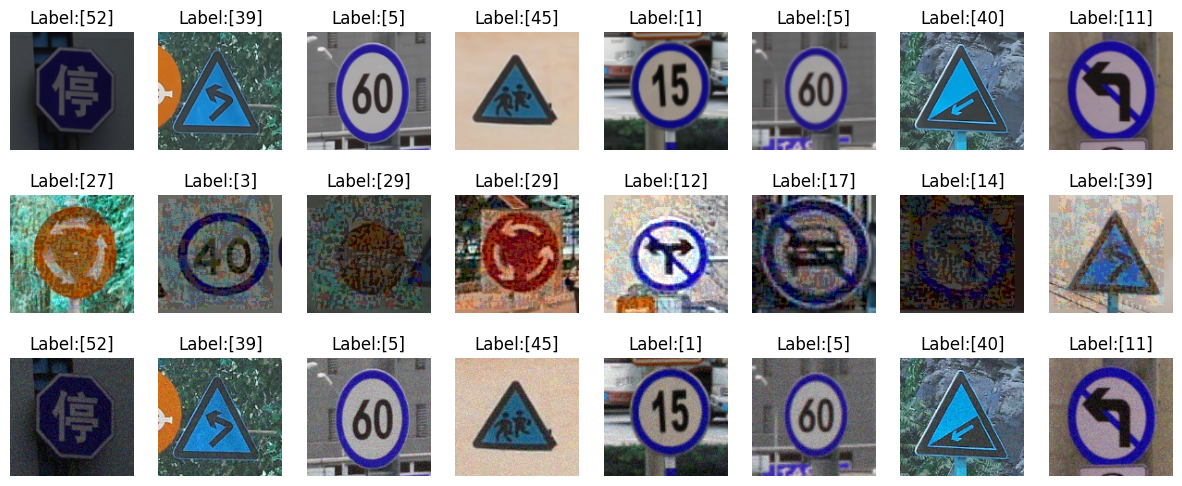

In [10]:
# Step 6: Plot original, noisy and malicious inputs
NUM_OF_ROWS = 3
NUM_OF_COLS = 8
fig, ax = plt.subplots(NUM_OF_ROWS,NUM_OF_COLS, figsize=(15,6))

for i in range(NUM_OF_COLS):
    uniform_noise = np.random.uniform(low=-1.0,high=1.0,size=testX[i].shape) * ATTACK_POWER
    noise = testX[i:i+1] + uniform_noise
    
    benign_pred = model.predict(testX[i:i+1])
    malicious_pred = model.predict(x_test_adv_fgsm[i:i+1])
    noise_pred = model.predict(noise)

    ax[0,i].imshow(testX[i])
    ax[1,i].imshow(x_test_adv_fgsm[i])
    ax[2,i].imshow(noise[0].clip(0.0,1.0))

    ax[0,i].set_title('Label:' + str(benign_pred.argmax(axis=1)))
    ax[1,i].set_title('Label:' + str(malicious_pred.argmax(axis=1)))
    ax[2,i].set_title('Label:' + str(noise_pred.argmax(axis=1)))
    ax[0,i].axis('off')
    ax[1,i].axis('off')
    ax[2,i].axis('off')
plt.show()

In [11]:
# Step 7 save matrices
np.savez('milestone-4-1.npz', trainX=trainX, testX=testX,
         trainY=trainY, testY=testY, predictions=predictions,
         x_test_adv_fgsm=x_test_adv_fgsm,
         y_test_adv_fgsm=y_test_adv_fgsm,
         y_adv_pred_fgsm_hat=y_adv_pred_fgsm_hat)